
<center><h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;"> Time Series Forecasting using RNN, LSTM, GRU</h1></center>

In [3]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.subplots as sp
import statsmodels.api as sm
import datetime as dt
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import cufflinks as cf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv("/content/DailyDelhiClimateTest.csv", parse_dates=['date'],index_col="date")
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913,85.870,2.743,59.000
2017-01-02,18.500,77.222,2.894,1018.278
2017-01-03,17.111,81.889,4.017,1018.333
2017-01-04,18.700,70.050,4.545,1015.700
2017-01-05,18.389,74.944,3.300,1014.333
...,...,...,...,...
2017-04-20,34.500,27.500,5.562,998.625
2017-04-21,34.250,39.375,6.963,999.875
2017-04-22,32.900,40.900,8.890,1001.600


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantemp,114.000,21.713,6.360,11.000,16.437,19.875,27.705,34.500
humidity,114.000,56.258,19.068,17.750,39.625,57.750,71.903,95.833
wind_speed,114.000,8.144,3.588,1.388,5.564,8.069,10.069,19.314
meanpressure,114.000,1004.035,89.475,59.000,1007.438,1012.739,1016.740,1022.810


In [7]:
# creating new features for EDA
df["year"] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df["date"] = df.index.date
df.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day,dayofweek,date
date,,,,,,,,,
2017-01-01,15.913,85.870,2.743,59.000,2017,1,1,6,2017-01-01
2017-01-02,18.500,77.222,2.894,1018.278,2017,1,2,0,2017-01-02
2017-01-03,17.111,81.889,4.017,1018.333,2017,1,3,1,2017-01-03
2017-01-04,18.700,70.050,4.545,1015.700,2017,1,4,2,2017-01-04
2017-01-05,18.389,74.944,3.300,1014.333,2017,1,5,3,2017-01-05


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
 4   year          114 non-null    int32  
 5   month         114 non-null    int32  
 6   day           114 non-null    int32  
 7   dayofweek     114 non-null    int32  
 8   date          114 non-null    object 
dtypes: float64(4), int32(4), object(1)
memory usage: 7.1+ KB


In [58]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming df is your DataFrame
# Compute skewness
skewness = df.apply(skew)
print("Skewness:\n", skewness)

# Compute kurtosis
kurtosis_values = df.apply(kurtosis)
print("\nKurtosis:\n", kurtosis_values)


Skewness:
 meantemp      0.436
humidity     -0.163
wind_speed    0.491
dtype: float64

Kurtosis:
 meantemp     -1.058
humidity     -1.117
wind_speed    0.188
dtype: float64


In [65]:
import numpy as np
import pandas as pd




# 1. Creating a Vector (Extracting a Single Column)
vector = df["meantemp"].values
print("Vector:\n", vector)

# 2. Creating a Factor (Categorizing Temperature Levels)
df["Temp_Factor"] = pd.cut(df["meantemp"], bins=[0, 17, 19, 25], labels=["Cold", "Warm", "Hot"])
factor = df["Temp_Factor"]
print("\nFactor:\n", factor)

# 3. Creating a List (Extracting Multiple Columns as a List)
df_list = df.head(5).values.tolist()
print(df_list)

matrix = df.values

# Print Matrix
print("Matrix:\n", matrix)

# 5. Creating a Data Frame (Extracted Subset of Original Data)
df_subset = df[["meantemp", "humidity", "wind_speed"]]
#df_subset = df[["meantemp", "humidity", "wind_speed", "meanpressure"]] # original line

# Print DataFrame
print("\nData Frame:\n", df_subset)


Vector:
 [15.91304348 18.5        17.11111111 18.7        18.38888889 19.31818182
 14.70833333 15.68421053 14.57142857 12.11111111 11.         11.78947368
 13.23529412 13.2        16.43478261 14.65       11.72222222 13.04166667
 14.61904762 15.26315789 15.39130435 18.44       18.11764706 18.34782609
 21.         16.17857143 16.5        14.86363636 15.66666667 16.44444444
 16.125      15.25       17.09090909 15.63636364 18.7        18.63157895
 16.88888889 15.125      15.7        15.375      14.66666667 15.625
 16.25       16.33333333 16.875      17.57142857 20.25       21.3
 21.125      22.36363636 23.375      21.83333333 19.125      18.625
 19.125      19.         18.75       19.875      23.33333333 24.46153846
 23.75       20.5        19.125      19.75       20.         22.625
 21.54545455 20.78571429 19.9375     18.53333333 17.375      17.44444444
 18.         19.875      24.         20.9        24.69230769 24.66666667
 23.33333333 25.         27.25       28.         28.91666667 26.

<h3 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">EDA & Visualization</h3>

In [9]:
# Get the 'xgridoff' template
xgridoff_template = pio.templates['xgridoff']

# Customize the template for dark mode
xgridoff_template.layout.paper_bgcolor = 'rgb(25, 25, 25)'  # very dark gray background
xgridoff_template.layout.plot_bgcolor = 'rgb(35, 35, 35)'  # Dark gray plot background
xgridoff_template.layout.font.color = 'lightgray'  # Light gray font color

# Adjust gridline color and width
xgridoff_template.layout.xaxis.gridcolor = 'rgba(200, 200, 200, 0.3)'  # Light gray with transparency
xgridoff_template.layout.yaxis.gridcolor = 'rgba(200, 200, 200, 0.3)'  # Light gray with transparency
xgridoff_template.layout.xaxis.gridwidth = 1  # Set gridline width
xgridoff_template.layout.yaxis.gridwidth = 1  # Set gridline width

# Update Plotly templates with the modified 'xgridoff' template
pio.templates['xgridoff_dark'] = xgridoff_template

<h3 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Line Plots 📈</h3>

## Plotting features over time (daily):


In [10]:
fig_meantemp = px.line(df, x=df.index, y='meantemp', title='Mean Temperature Over Time')
fig_meantemp.update_layout(template='xgridoff_dark', title_x=0.5, xaxis_title="Date")
fig_meantemp.show()

fig_humidity = px.line(df, x=df.index, y='humidity', title='Humidity Over Time')
fig_humidity.update_layout(template='xgridoff_dark', title_x=0.5, xaxis_title="Date")
fig_humidity.show()

fig_wind_speed = px.line(df, x=df.index, y='wind_speed', title='Wind Speed Over Time')
fig_wind_speed.update_layout(template='xgridoff_dark', title_x=0.5, xaxis_title="Date")
fig_wind_speed.show()

fig_meanpressure = px.line(df, x=df.index, y='meanpressure', title='Mean Pressure Over Time')
fig_meanpressure.update_layout(template='xgridoff_dark', title_x=0.5, xaxis_title="Date")
fig_meanpressure.show()

## Plotting Seasonal Decompositions:

In [54]:
# Perform seasonal decomposition
# Calculate the period automatically using the frequency of the index
period = pd.infer_freq(df.index)
if period is None:
    period = 365  # Set a default period if frequency can't be inferred
else:
    # Check if the period is a string and represents a single day ('D')
    if isinstance(period, str) and period == 'D':
        period = 1  # Set period to 1 for daily frequency
    else:
        period = pd.to_timedelta(period).days  # Convert frequency to days for other frequencies

# Use the calculated period in seasonal_decompose
result = seasonal_decompose(df['meantemp'], model='additive', period=period)

# Plot the decomposed components
fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=['Observed', 'Trend', 'Seasonal', 'Residual'])
fig.add_trace(go.Scatter(x=df.index, y=result.observed, mode='lines', name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=result.trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=result.seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=result.resid, mode='lines', name='Residual'), row=4, col=1)
fig.update_layout(template= 'xgridoff_dark',height=800, title='Seasonal Decomposition of Mean Temperature')
fig.show()

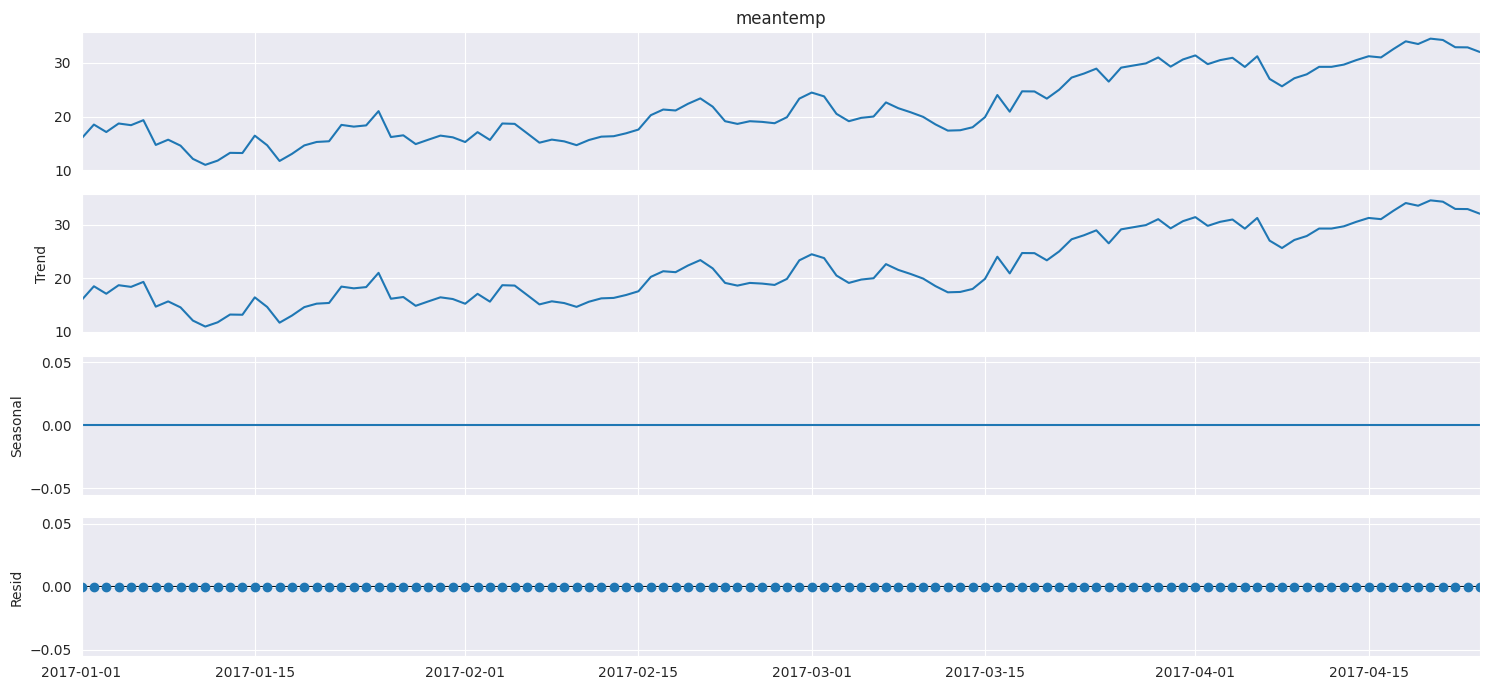

In [57]:
plt.rcParams['figure.figsize'] = [15, 7]

# Instead of resampling to monthly, use the original daily data
# or resample to a frequency that has enough data points for 2 cycles
# For example, if you have at least 2 years of data, you can use 'M' for monthly
# or 'Q' for quarterly
# Here, we are using the original daily data, assuming it has enough data points
data_to_decompose = df['meantemp']

# Perform seasonal decomposition
# Assuming you have at least 2 years of daily data

# Calculate the period automatically using the frequency of the index
period = pd.infer_freq(df.index)
if period is None:
    period = 365  # Set a default period if frequency can't be inferred
else:
    # Check if the period is a string and represents a single day ('D')
    if isinstance(period, str) and period == 'D':
        period = 1  # Set period to 1 for daily frequency
    else:
        period = pd.to_timedelta(period).days  # Convert frequency to days for other frequencies

# Check if the data has enough observations for 2 complete cycles
if len(data_to_decompose) < 2 * period:
    # If not enough observations, adjust the period to the maximum possible
    period = len(data_to_decompose) // 2  # Ensure at least 2 cycles
    print(f"Warning: Not enough data for 2 complete cycles. Using period={period}")


decomposition = sm.tsa.seasonal_decompose(data_to_decompose, model='additive', period=period)

# Plot the decomposition
fig = decomposition.plot()
plt.show()

## Plotting Features over time (Month):

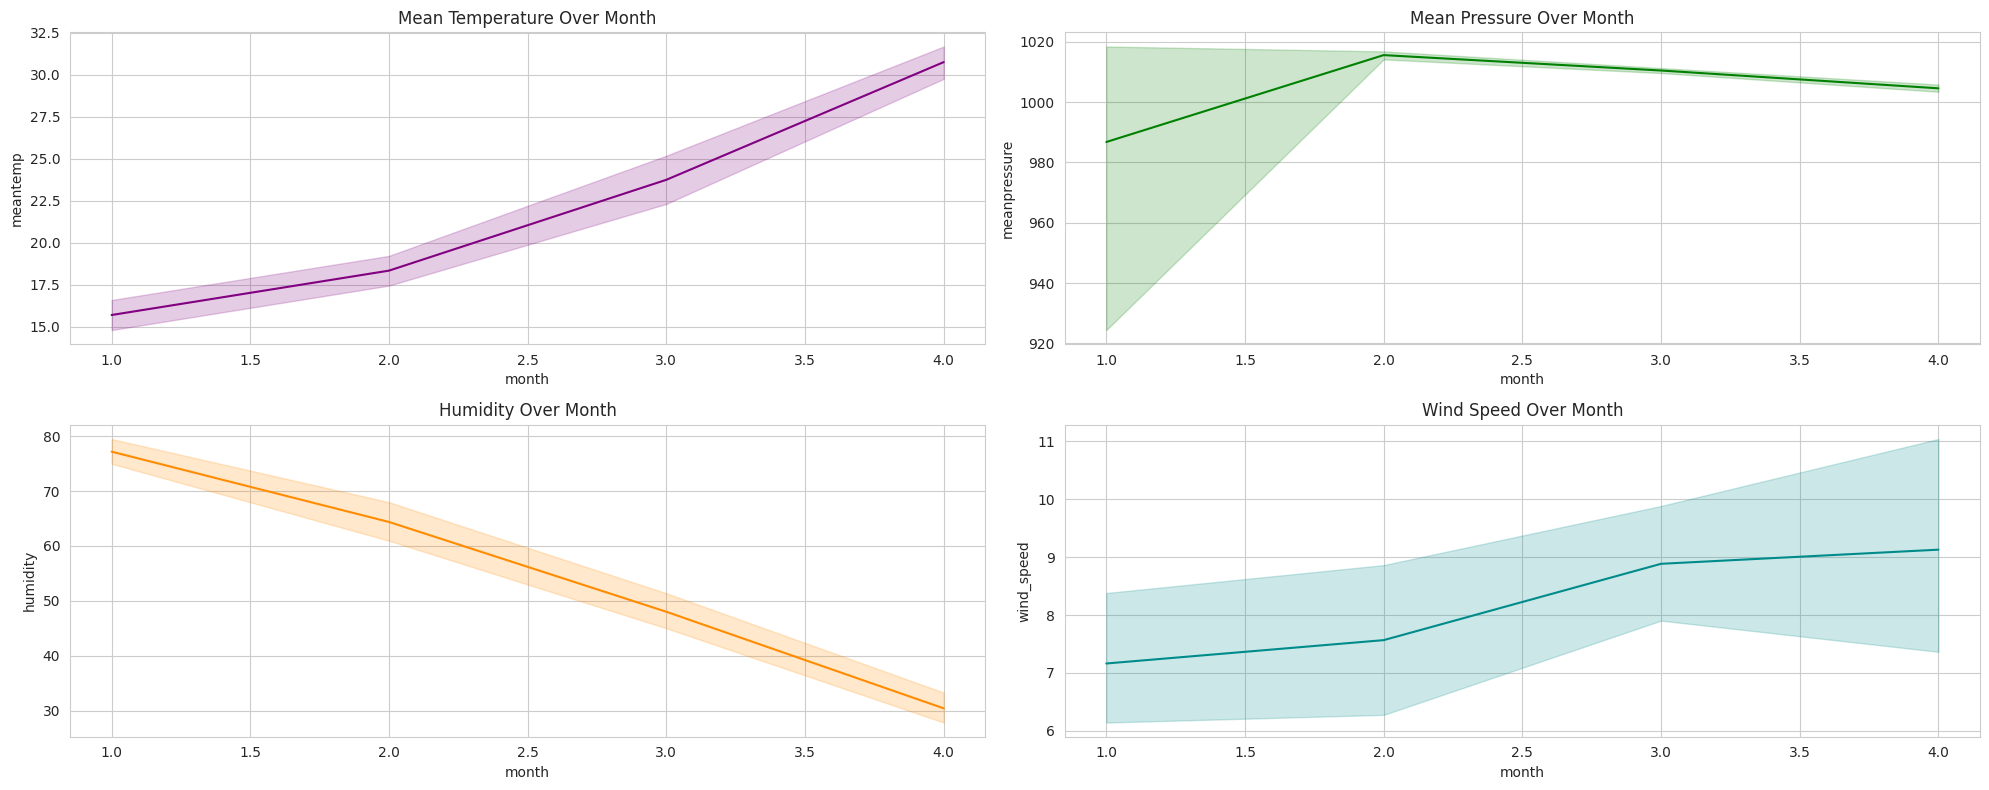

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))
sns.set_style('darkgrid')

# Plot each parameter against the 'month'
sns.lineplot(x='month', y='meantemp', data=df, color='purple', ax=axes[0][0])
axes[0][0].set_title('Mean Temperature Over Month')

sns.lineplot(x='month', y='humidity', data=df, color='darkorange', ax=axes[1][0])
axes[1][0].set_title('Humidity Over Month')

sns.lineplot(x='month', y='meanpressure', data=df, color='green', ax=axes[0][1])
axes[0][1].set_title('Mean Pressure Over Month')

sns.lineplot(x='month', y='wind_speed', data=df, color='darkcyan', ax=axes[1][1])
axes[1][1].set_title('Wind Speed Over Month')

plt.tight_layout()
plt.show()

## Plotting temprature over the years by month:

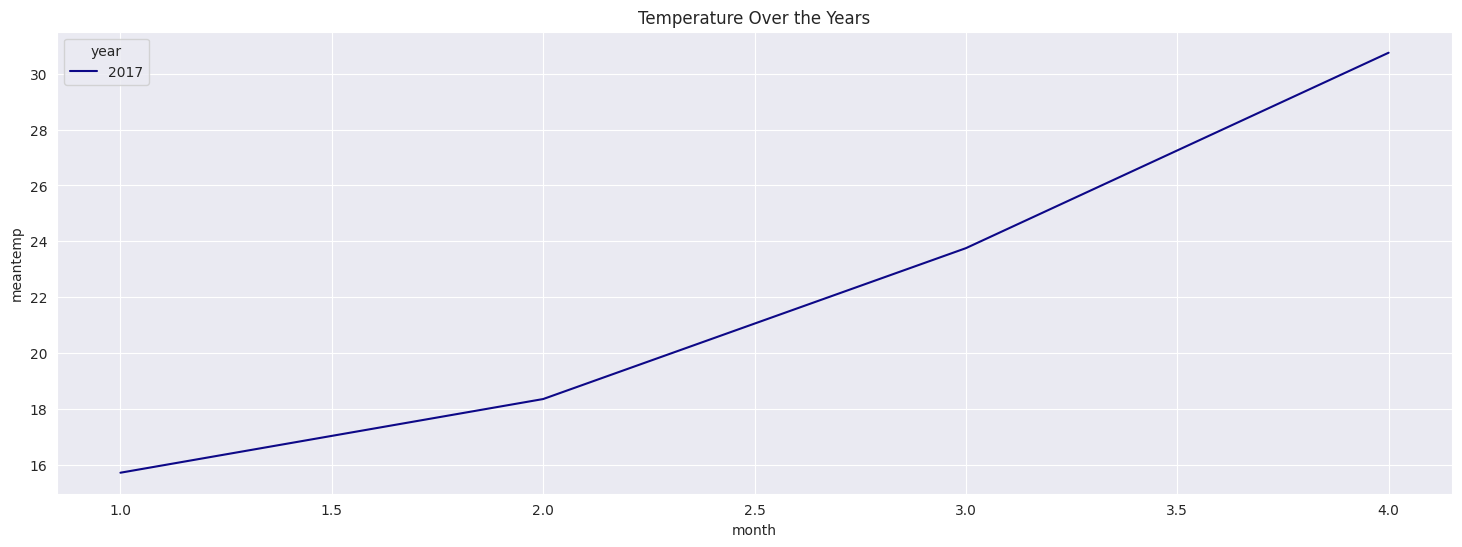

In [17]:
# Create a figure with the specified size
plt.figure(figsize=(18, 6))

sns.set_style('darkgrid')

plt.title("Temperature Over the Years")
sns.lineplot(data=df, x='month', y='meantemp', hue='year', palette='plasma', ci= None);

<h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Plotting Correlation and Heatmaps</h1>

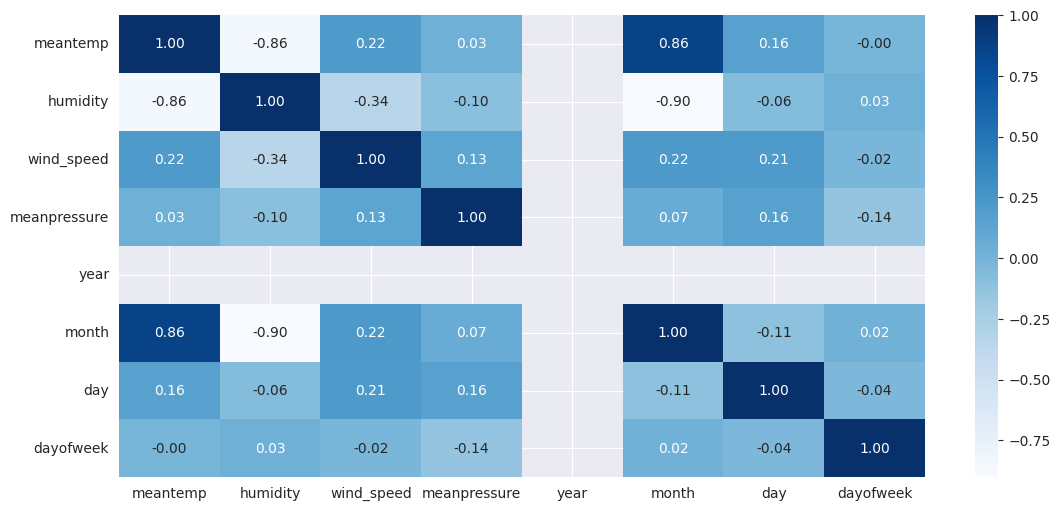

In [18]:
plt.figure(figsize=(13, 6))
sns.heatmap(df.select_dtypes('number').corr(), cmap='Blues', annot=True, fmt='.2f');

<h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Box Plots</h1>

## Monthly Distributions of features:

In [19]:
# Box plots by Month
fig = px.box(df, x='month', y='meantemp', title='Monthly Distribution of Mean Temperatures', template='xgridoff_dark')
fig.show()

fig = px.box(df, x='month', y='humidity', title='Monthly Distribution of Mean Humidity', template='xgridoff_dark')
fig.show()

fig = px.box(df, x='month', y='wind_speed', title='Monthly Distribution of Mean wind_speed', template='xgridoff_dark')
fig.show()

fig = px.box(df, x='month', y='meanpressure', title='Monthly Distribution of Mean Pressure', template='xgridoff_dark')
fig.show()

<h3 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Scatterplots</h3>

In [20]:
print(df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].dtypes)

meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object


## Histograms with Seaborn:

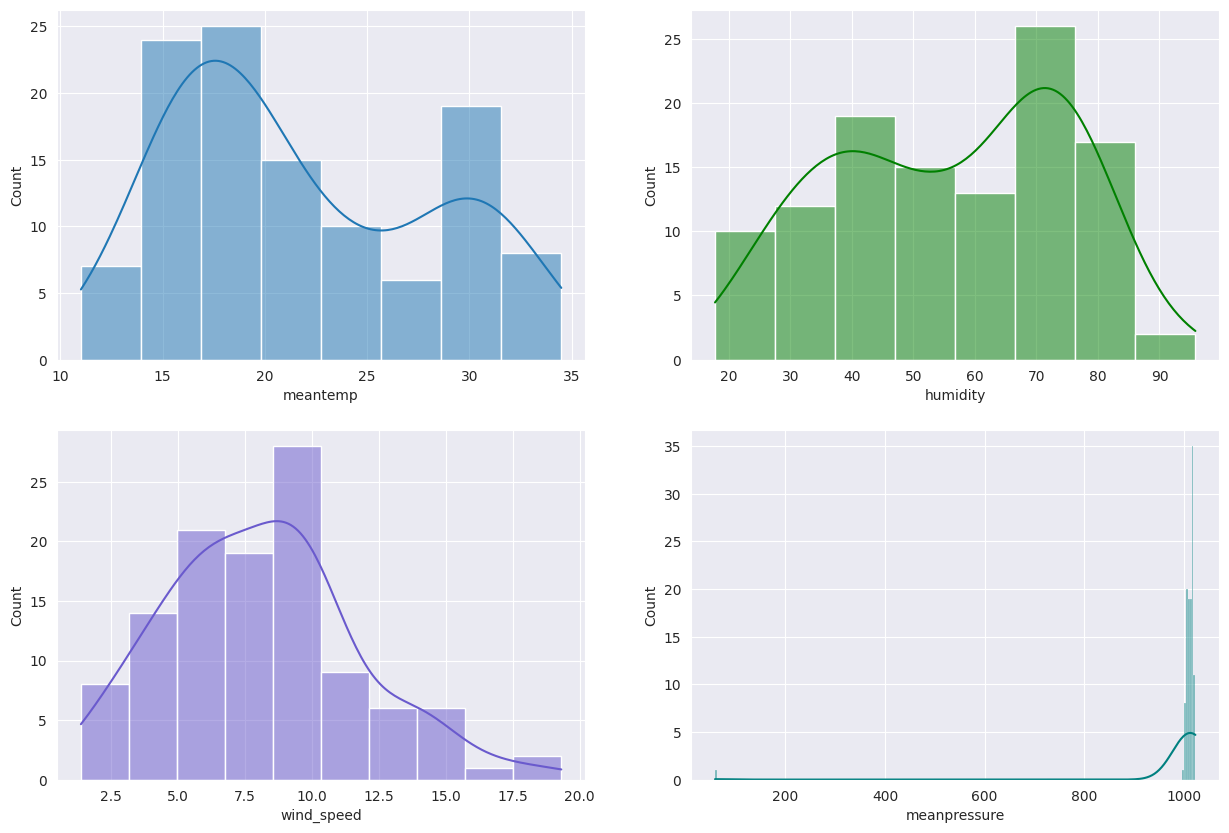

In [21]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot histograms with KDE
sns.histplot(data=df, x="meantemp", ax=ax[0][0], kde=True)
sns.histplot(data=df, x="humidity", ax=ax[0][1], kde=True, color='green')
sns.histplot(data=df, x="wind_speed", ax=ax[1][0], kde=True, color='slateblue')
sns.histplot(data=df, x="meanpressure", ax=ax[1][1], kde=True, color='teal')
plt.show()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
 4   year          114 non-null    int32  
 5   month         114 non-null    int32  
 6   day           114 non-null    int32  
 7   dayofweek     114 non-null    int32  
 8   date          114 non-null    object 
dtypes: float64(4), int32(4), object(1)
memory usage: 7.1+ KB


In [23]:
df = df[['meantemp', 'humidity', 'wind_speed']]
df.head()

,meantemp,humidity,wind_speed
date,,,
2017-01-01,15.913,85.870,2.743
2017-01-02,18.500,77.222,2.894
2017-01-03,17.111,81.889,4.017
2017-01-04,18.700,70.050,4.545
2017-01-05,18.389,74.944,3.300


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   meantemp    114 non-null    float64
 1   humidity    114 non-null    float64
 2   wind_speed  114 non-null    float64
dtypes: float64(3)
memory usage: 3.6 KB


In [25]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
dl_train, dl_test = df.iloc[:train_size], df.iloc[train_size:]
print(len(dl_train), len(dl_test))

91 23


# find out what scaling to perform

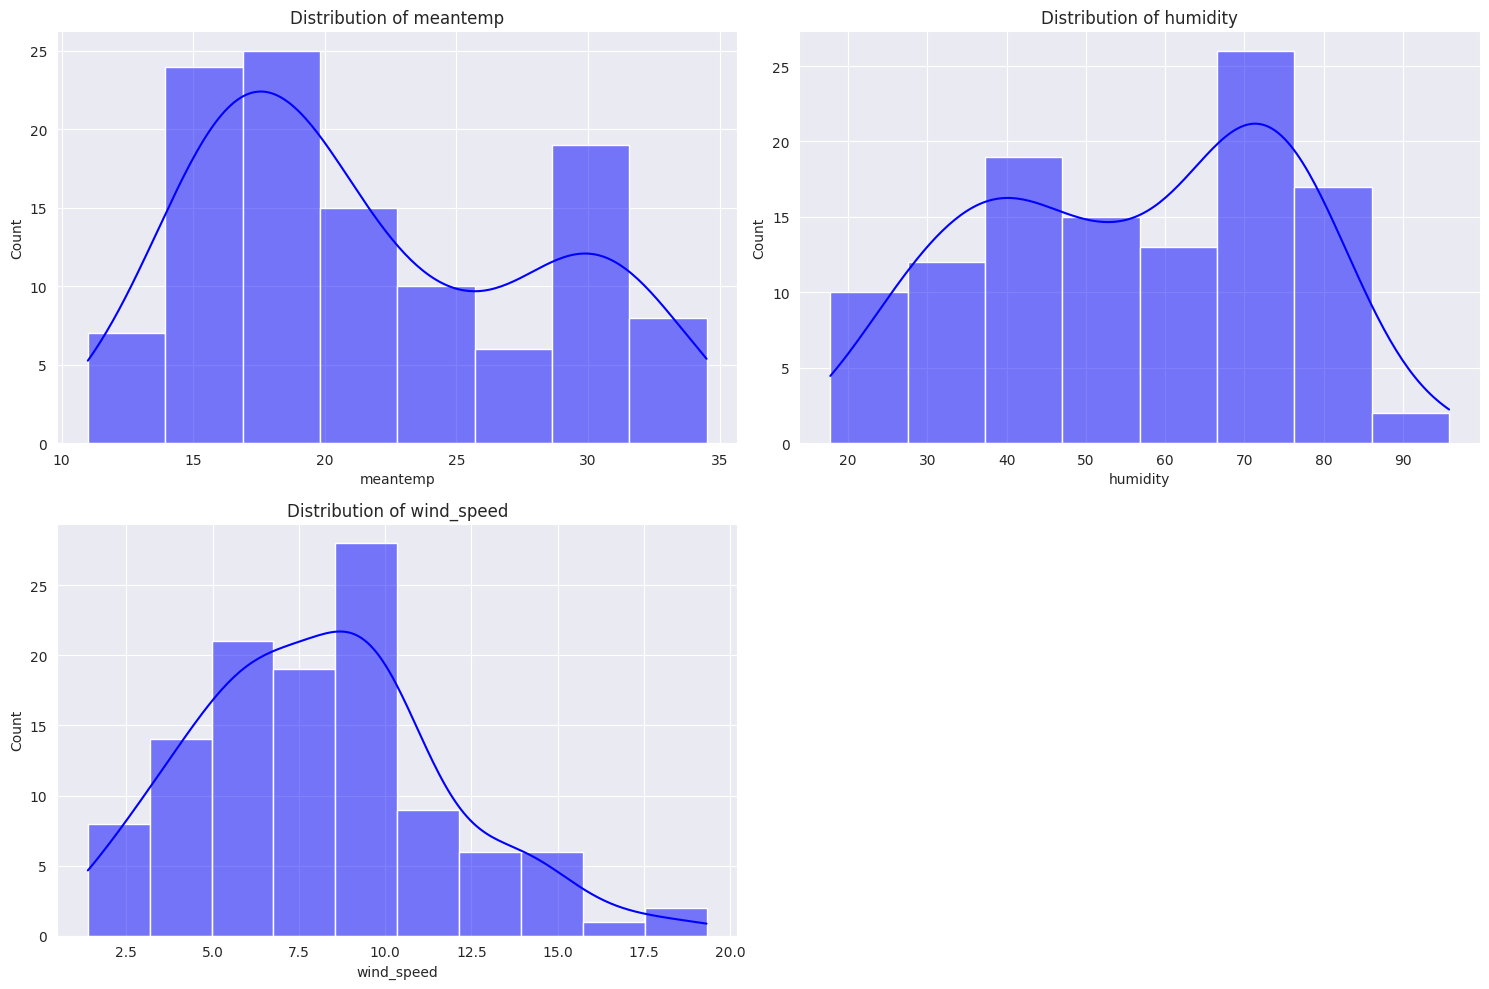

In [26]:
def plot_feature_distributions(df):
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(df, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df[feature], kde=True, color='blue')
        plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()

plot_feature_distributions(df)

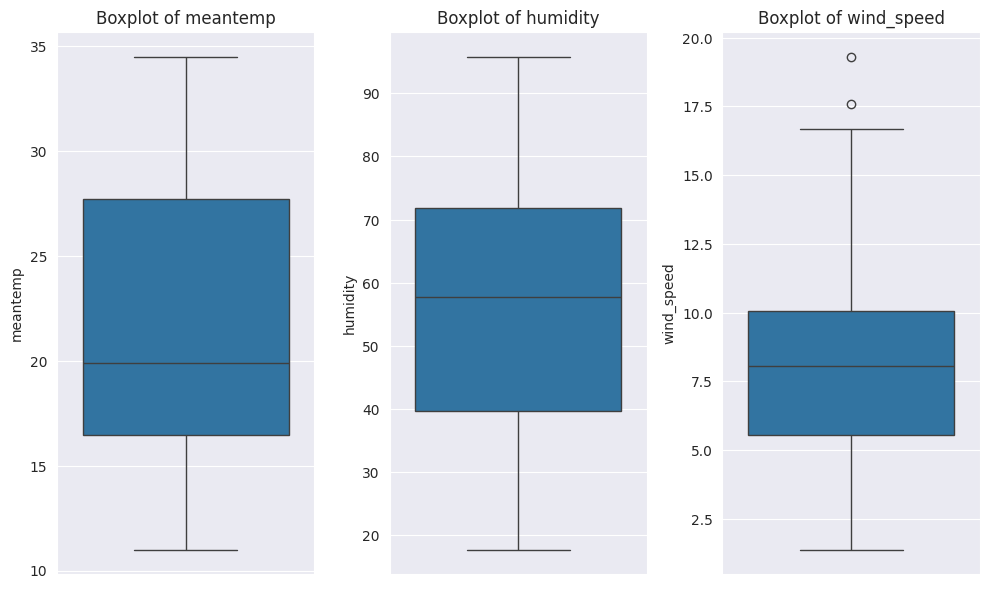

In [27]:
f_columns = ['meantemp', 'humidity', 'wind_speed']
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['meantemp'])
plt.title('Boxplot of meantemp')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['humidity'])
plt.title('Boxplot of humidity')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['wind_speed'])
plt.title('Boxplot of wind_speed')

plt.tight_layout()
plt.show()

In [28]:
robust_scaler = RobustScaler()   # scaler for wind_speed cuz it has outliers and is skewed.
minmax_scaler = MinMaxScaler()  # scaler for humidity
target_transformer = MinMaxScaler()   # scaler for target (meantemp)

dl_train['wind_speed'] = robust_scaler.fit_transform(dl_train[['wind_speed']])
dl_train['humidity'] = minmax_scaler.fit_transform(dl_train[['humidity']])
dl_train['meantemp'] = target_transformer.fit_transform(dl_train[['meantemp']])

dl_test['wind_speed'] = robust_scaler.transform(dl_test[['wind_speed']])
dl_test['humidity'] = minmax_scaler.transform(dl_test[['humidity']])
dl_test['meantemp'] = target_transformer.transform(dl_test[['meantemp']])

display(df.head()) # Before

,meantemp,humidity,wind_speed
date,,,
2017-01-01,15.913,85.870,2.743
2017-01-02,18.500,77.222,2.894
2017-01-03,17.111,81.889,4.017
2017-01-04,18.700,70.050,4.545
2017-01-05,18.389,74.944,3.300


In [29]:
display(dl_train.head()) # after

,meantemp,humidity,wind_speed
date,,,
2017-01-01,0.241,0.838,-1.147
2017-01-02,0.368,0.697,-1.113
2017-01-03,0.300,0.773,-0.862
2017-01-04,0.378,0.580,-0.744
2017-01-05,0.363,0.659,-1.023


# RNN

time_steps: This is the number of previous time steps that will be used to predict the next value in the sequence. This is essentially how many past values the model will consider to make the prediction.

Xs will store the input sequences (time steps).
ys will store the corresponding target values that follow the input sequence.

How it works:

The loop iterates over the data, creating sequences of time_steps length from the feature data (X), and pairs them with the corresponding value from the target data (y).<br>
For example, if time_steps=3, it will take the first three values from X (let's say 10, 12, and 15) to predict the fourth value from y (which could be the value at time step 4).


In [30]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []   # Initialize empty lists to store input sequences and corresponding outputs
    for i in range(len(X) - time_steps):   # Iterate over the entire dataset, excluding the last few rows that can't form a sequence
        v = X.iloc[i:(i + time_steps)].values  # Select the sequence of 'time_steps' length from X starting at index 'i'
        Xs.append(v)      # Add the sequence to the list of inputs
        ys.append(y.iloc[i + time_steps])  # The output will be the value at the index 'i + time_steps' from the target variable 'y'
    return np.array(Xs), np.array(ys)  # Convert the lists into numpy arrays and return them

# Create sequences
sequence_length = 3
X_train, y_train = create_dataset(dl_train, dl_train['meantemp'], sequence_length)
X_test, y_test = create_dataset(dl_test, dl_test['meantemp'], sequence_length)

In [31]:
# Build the model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(100, activation='tanh', input_shape=(sequence_length, X_train.shape[2])))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=1, callbacks=[early_stopping])

# Evaluate the model
rnn_loss = rnn_model.evaluate(X_test, y_test)
print(f'Validation Loss: {rnn_loss}')

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0871 - val_loss: 0.0439
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.0133
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 - val_loss: 0.0148
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.0055
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.0084
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0195
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 - val_loss: 0.0191
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0219
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0170
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0257
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0138
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_lo

In [32]:
# Make predictions
rnn_pred = rnn_model.predict(X_test)
rnn_pred = target_transformer.inverse_transform(rnn_pred)  # Inverse transform to original scale

# Inverse transform the true values for comparison
y_test = y_test.reshape(-1, 1)
y_test = target_transformer.inverse_transform(y_test)

# Calculate RMSE and R2 scores
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_pred))
rnn_r2 = r2_score(y_test, rnn_pred)

print(f'RMSE: {rnn_rmse}')
print(f'R2 Score: {rnn_r2}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
RMSE: 1.507813170326015
R2 Score: 0.6469011420623805


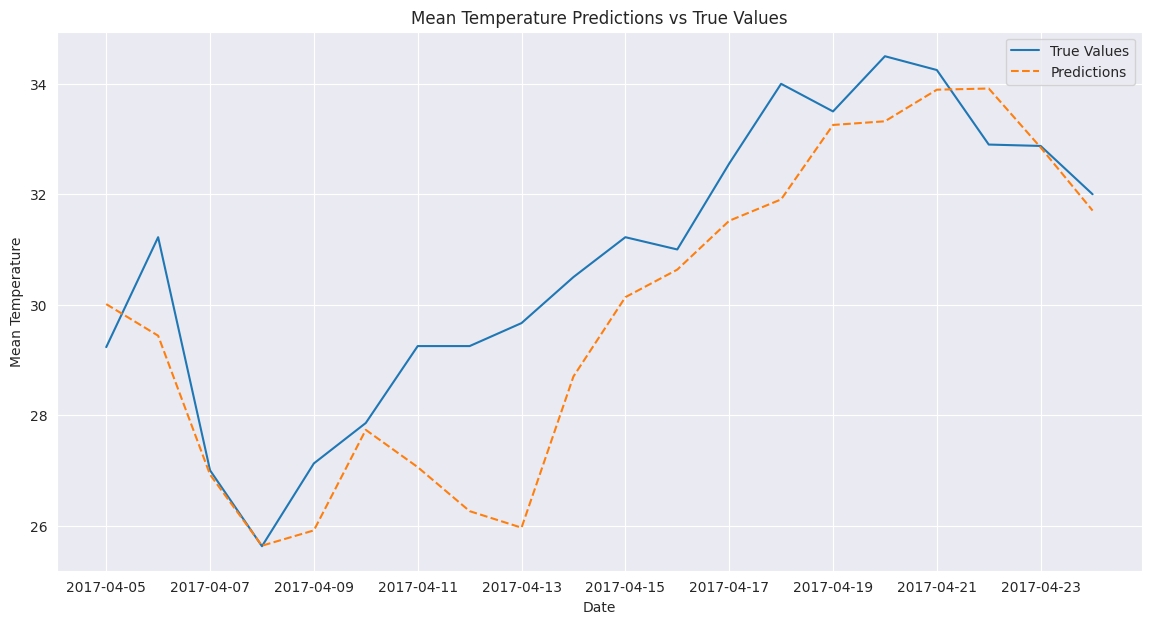

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Values')
plt.plot(df.index[-len(y_test):], rnn_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

In [34]:
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 100)                 │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,505 (123.07 KB)

 Trainable params: 10,501 (41.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,004 (82.05 KB)

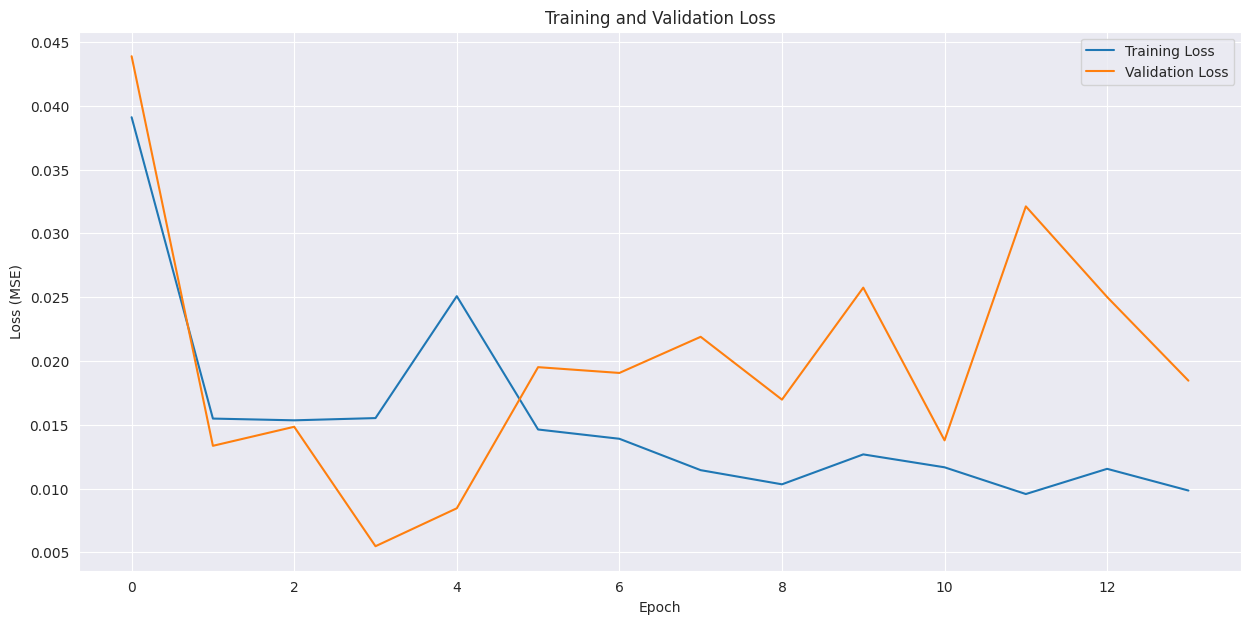

In [35]:
# Get training and validation losses from history
rnn_training_loss = history.history['loss']
rnn_validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(rnn_training_loss, label='Training Loss')
plt.plot(rnn_validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# LSTM

In [36]:
sequence_length = 3
X_train, y_train = create_dataset(dl_train, dl_train['meantemp'], sequence_length)
X_test, y_test = create_dataset(dl_test, dl_test['meantemp'], sequence_length)

In [37]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='tanh', input_shape=(sequence_length, X_train.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=1, callbacks=[early_stopping])

# Evaluate the model
lstm_loss = lstm_model.evaluate(X_test, y_test)
print(f'Validation Loss: {lstm_loss}')

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1413 - val_loss: 0.0664
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0186 - val_loss: 0.0129
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0152
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - val_loss: 0.0130
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0177
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0105
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.0125
Epoch 9/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0135
Epoch 10/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084 - val_loss: 0.0109
Epoch 11/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 12/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087 - val_l

In [38]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,105 (488.70 KB)

 Trainable params: 41,701 (162.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 83,404 (325.80 KB)

In [39]:
# Make predictions
lstm_pred = lstm_model.predict(X_test)
lstm_pred = target_transformer.inverse_transform(lstm_pred)  # Inverse transform to original scale

# Inverse transform the true values for comparison
y_test = y_test.reshape(-1, 1)
y_test = target_transformer.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


RMSE: 1.8046444740500398
R2 Score: 0.4941933206667226


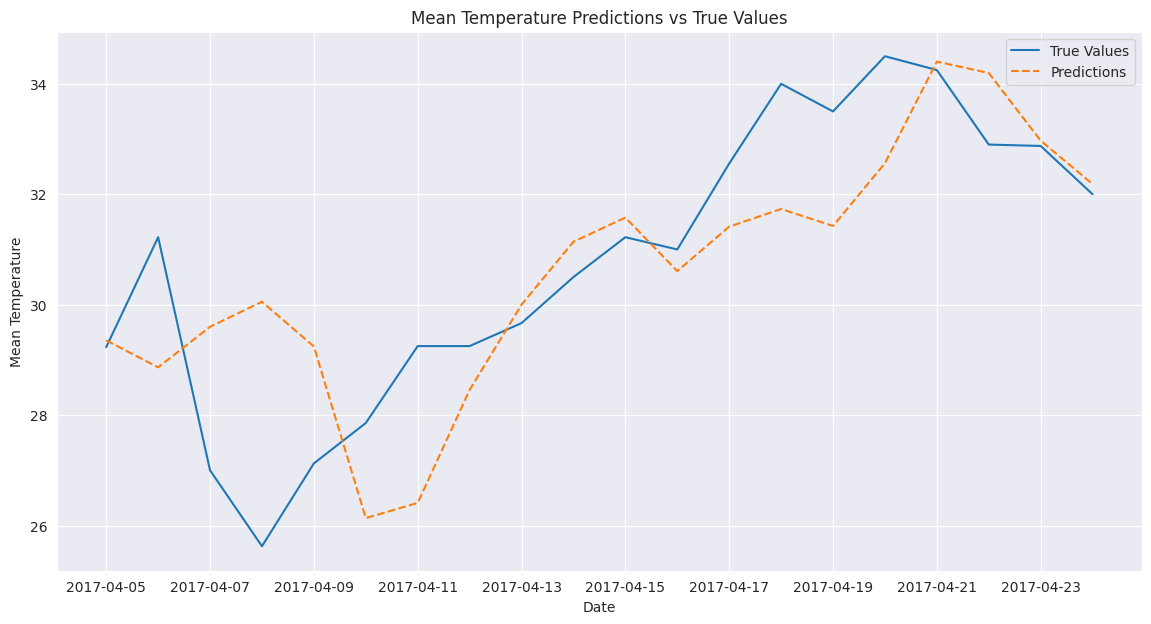

In [40]:
# Calculate RMSE and R2 scores
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_r2 = r2_score(y_test, lstm_pred)

print(f'RMSE: {lstm_rmse}')
print(f'R2 Score: {lstm_r2}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Values')
plt.plot(df.index[-len(y_test):], lstm_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

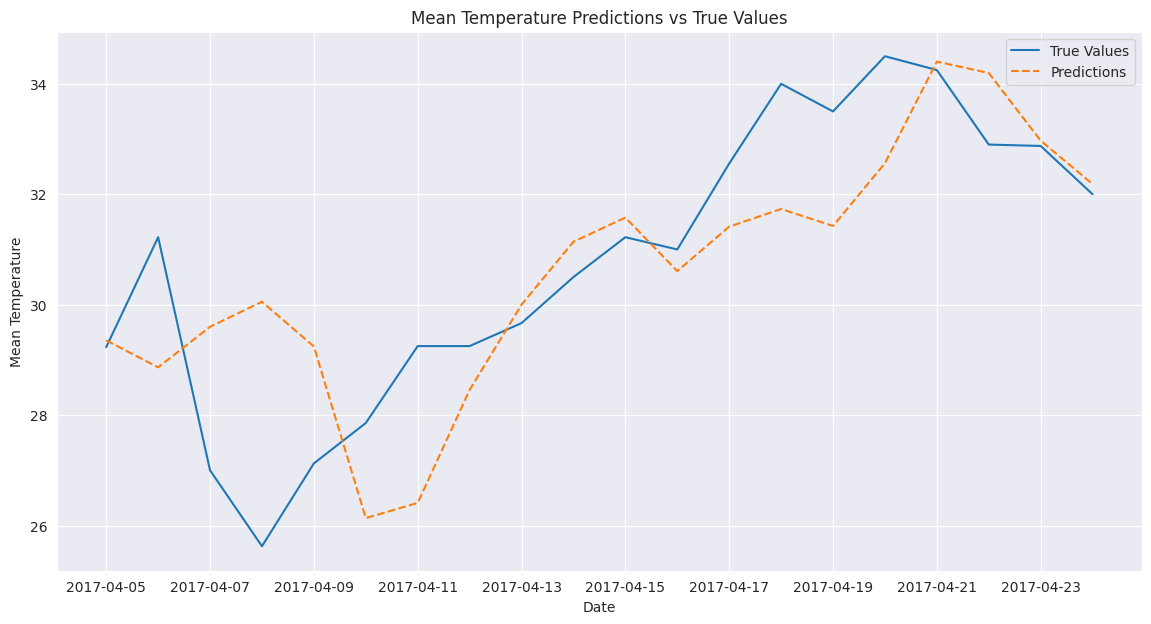

In [41]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Values')
plt.plot(df.index[-len(y_test):], lstm_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

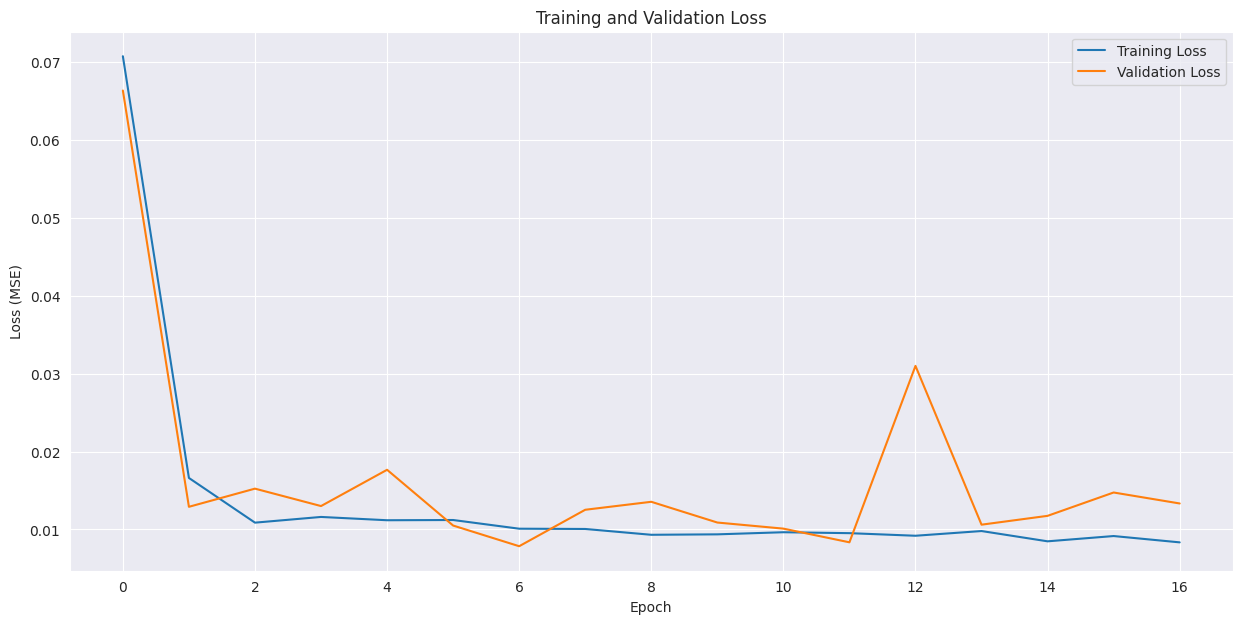

In [42]:
# Get training and validation losses from history
lstm_training_loss = history.history['loss']
lstm_validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(lstm_training_loss, label='Training Loss')
plt.plot(lstm_validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# GRU

In [43]:
# Create sequences
sequence_length = 3  # Example sequence length (adjust based on your data and experimentation)
X_train, y_train = create_dataset(dl_train, dl_train['meantemp'], sequence_length)
X_test, y_test = create_dataset(dl_test, dl_test['meantemp'], sequence_length)

In [44]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(100, activation='tanh', input_shape=(sequence_length, X_train.shape[2])))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = gru_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=1, callbacks=[early_stopping])

# Evaluate the model
gru_loss = gru_model.evaluate(X_test, y_test)
print(f'Validation Loss: {gru_loss}')

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0418 - val_loss: 0.0242
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - val_loss: 0.0088
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0098 - val_loss: 0.0056
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0161
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0152
Epoch 9/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 10/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 11/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - val_loss: 0.0117
Epoch 12/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_lo

In [45]:
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 100)                 │          31,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,805 (370.34 KB)

 Trainable params: 31,601 (123.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,204 (246.89 KB)

In [46]:
# Make predictions
gru_pred = gru_model.predict(X_test)
gru_pred = target_transformer.inverse_transform(gru_pred)  # Inverse transform to original scale

# Inverse transform the true values for comparison
y_test = y_test.reshape(-1, 1)
y_test = target_transformer.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


RMSE: 1.527009485835524
R2 Score: 0.6378531451240571


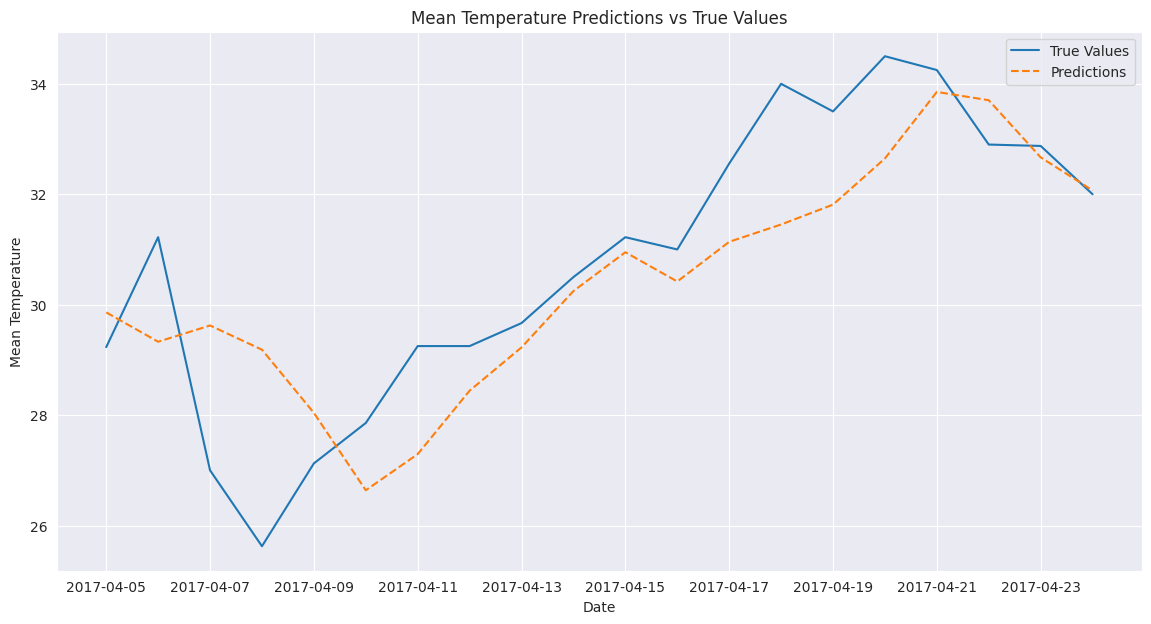

In [47]:
# Calculate RMSE and R2 scores
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_pred))
gru_r2 = r2_score(y_test, gru_pred)

print(f'RMSE: {gru_rmse}')
print(f'R2 Score: {gru_r2}')

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test, label='True Values')
plt.plot(df.index[-len(y_test):], gru_pred, label='Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Predictions vs True Values')
plt.legend()
plt.show()

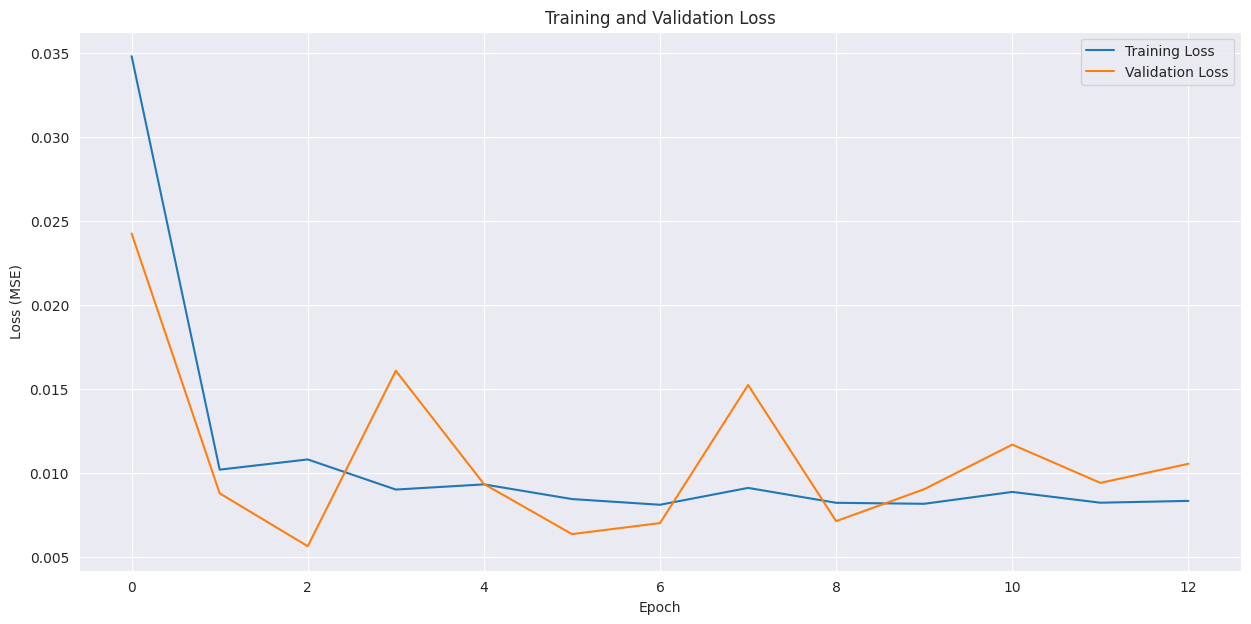

In [48]:
# Get training and validation losses from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot loss values over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Compare Models

In [49]:
rnn_mae = mean_absolute_error(y_test, rnn_pred)
rnn_rmse = np.sqrt(mean_squared_error(y_test, rnn_pred))
rnn_r2 = r2_score(y_test, rnn_pred)

lstm_mae = mean_absolute_error(y_test, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
lstm_r2 = r2_score(y_test, lstm_pred)


gru_mae = mean_absolute_error(y_test, gru_pred)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_pred))
gru_r2 = r2_score(y_test, gru_pred)

data = {
    'Model': ['RNN', 'LSTM', 'GRU'],
    'MAE': [rnn_mae, lstm_mae, gru_mae],
    'RMSE': [rnn_rmse, lstm_rmse, gru_rmse],
    'R2': [rnn_r2, lstm_r2, gru_r2]
}

compare_df = pd.DataFrame(data)
compare_df

,Model,MAE,RMSE,R2
0,RNN,1.119,1.508,0.647
1,LSTM,1.393,1.805,0.494
2,GRU,1.207,1.527,0.638


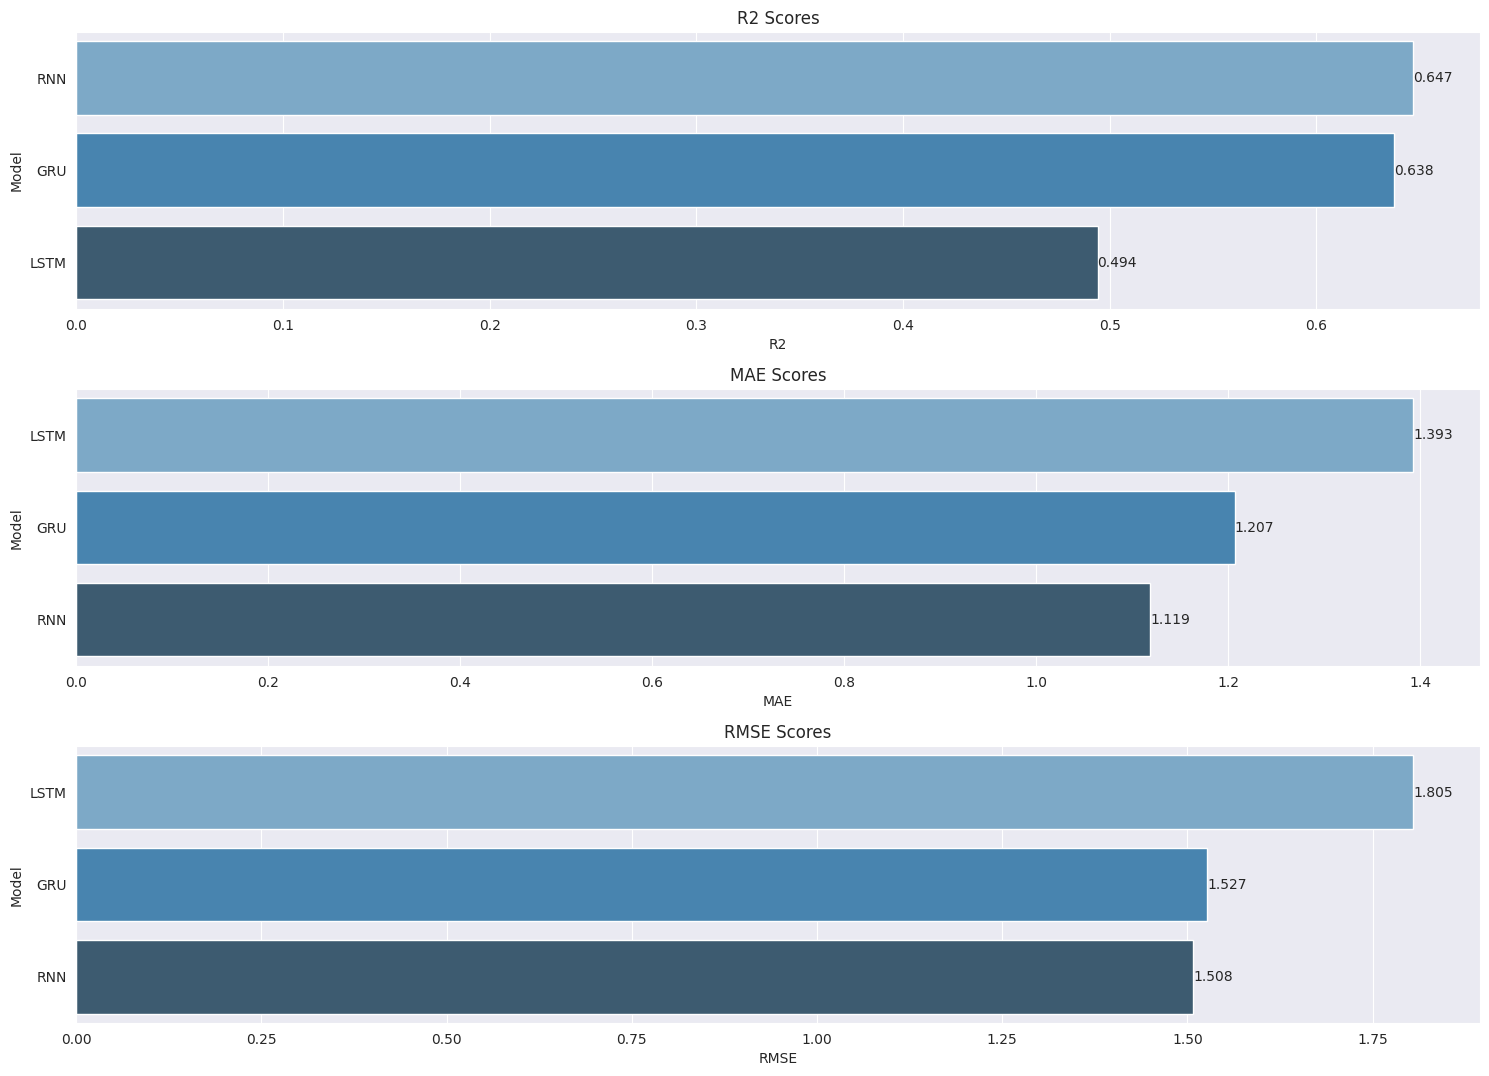

In [50]:
# add labels to the bars
def labels(ax):
    for p in ax.patches:
        width = p.get_width()
        ax.text(width,
                p.get_y() + p.get_height() / 2,
                '{:.3f}'.format(width),
                ha='left',
                va='center')

# Create a figure with subplots
plt.figure(figsize=(15, 14))

# Plot R2 Scores
plt.subplot(411)
compare_df = compare_df.sort_values(by="R2", ascending=False)
ax = sns.barplot(x="R2", y="Model", data=compare_df, palette="Blues_d")
labels(ax)
plt.title('R2 Scores')

# Plot MAE Scores
plt.subplot(412)
compare_df = compare_df.sort_values(by="MAE", ascending=False)
ax = sns.barplot(x="MAE", y="Model", data=compare_df, palette="Blues_d")
labels(ax)
plt.title('MAE Scores')

# Plot RMSE Scores
plt.subplot(413)
compare_df = compare_df.sort_values(by="RMSE", ascending=False)
ax = sns.barplot(x="RMSE", y="Model", data=compare_df, palette="Blues_d")
labels(ax)
plt.title('RMSE Scores')
plt.tight_layout()
plt.show()